# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

## Helper functions
Set of helper functions

In [0]:
%matplotlib inline
import pickle
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive

/content/drive


In [0]:
!ls

'My Drive'


In [0]:
%cd My\ Drive

/content/drive/My Drive


In [0]:
%cd Facial-Similarity-with-Siamese-Networks-in-Pytorch/

/content/drive/My Drive/Facial-Similarity-with-Siamese-Networks-in-Pytorch


In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [0]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    custom_testing_dir = "./data/faces/custom_testing/test"
    custom_labeled_dir = "./data/faces/custom_testing/labeled"
    train_batch_size = 64
    train_number_epochs = 15

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
#                 print(img1_tuple[0])
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
#         print(img0)
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
#         print(img0)
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [0]:
class SiameseNetworkDatasetMyTest(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[index]#random.choice(self.imageFolderDataset.imgs)
#         print("Image tuple 0 : ",img0_tuple)
        img0 = Image.open(img0_tuple[0])
        img0 = img0.convert("L")
        if self.transform is not None:
            img0 = self.transform(img0)        
        return img0, torch.from_numpy(np.array([int(img0_tuple[1])],dtype=np.int32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [0]:
class SiameseNetworkDatasetMyLabel(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[index]#random.choice(self.imageFolderDataset.imgs)
#         print("Label: ",img0_tuple, img0_tuple[1])
        img0 = Image.open(img0_tuple[0])
        img0 = img0.convert("L")
        if self.transform is not None:
            img0 = self.transform(img0)        
        return img0, torch.from_numpy(np.array([int(img0_tuple[1])],dtype=np.int32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.CenterCrop((50,50)),
                                                                      transforms.ToTensor(),
#                                                                       transforms.Normalize((0.5), (0.5))
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

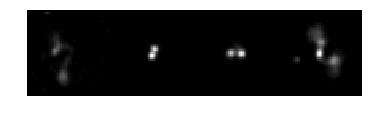

(2, 1, 50, 50)


In [0]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=2)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[1].numpy().shape)

## Neural Net Definition
We will use a standard convolutional neural network

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*50*50, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 4))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2=None):
        output1 = self.forward_once(input1)
        if input2 is None:
          return output1
        output2 = self.forward_once(input2)
        return output1, output2
        

## Contrastive Loss

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training Time!

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork()
net.to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.6641552448272705

Epoch number 0
 Current loss 1.0682928562164307

Epoch number 0
 Current loss 0.9094939231872559

Epoch number 1
 Current loss 0.8323596715927124

Epoch number 1
 Current loss 0.6818375587463379

Epoch number 1
 Current loss 0.9199447631835938

Epoch number 2
 Current loss 0.7245252132415771

Epoch number 2
 Current loss 0.6141626238822937

Epoch number 2
 Current loss 0.5131486654281616

Epoch number 3
 Current loss 0.6354104280471802

Epoch number 3
 Current loss 0.4733496308326721

Epoch number 3
 Current loss 0.42850518226623535

Epoch number 4
 Current loss 0.6217535734176636

Epoch number 4
 Current loss 0.3903195858001709

Epoch number 4
 Current loss 0.417709082365036

Epoch number 5
 Current loss 0.1931336522102356

Epoch number 5
 Current loss 0.3065322935581207

Epoch number 5
 Current loss 0.24458813667297363

Epoch number 6
 Current loss 0.22702312469482422

Epoch number 6
 Current loss 0.24002671241760254

Epoch number 6
 C

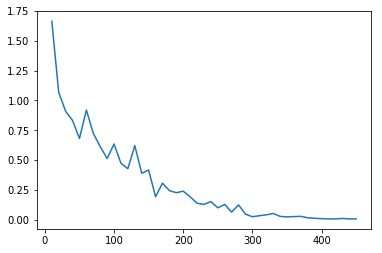

In [0]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Save the model ###

In [0]:
# torch.save(net,'model_80.pth')

In [0]:
# net = SiameseNetwork()
# net = torch.load('model_80.pth')
# net.eval()

In [0]:
folder_dataset_test = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDatasetMyTest(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.CenterCrop((50,50)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
dataloader = DataLoader(siamese_dataset,num_workers=1,batch_size=1,shuffle=False)
dataiter = iter(dataloader)
# print(len(dataloader))
training_embedding = []
for i in range(len(dataloader)):
  x0,label_test= next(dataiter)
  label_test = label_test.cuda()
  label_test = (label_test.tolist())[0][0]
  x0 = x0.cuda() 
  output1 = net(Variable(x0))
  training_embedding.append([output1.cpu().detach().numpy().tolist()[0],label_test])
# print(training_embedding)
with open('train_embedding_new.pkl','wb') as f:
  pickle.dump(training_embedding, f)
  
with open('train_embedding_new.pkl','rb') as f:
  l = pickle.load(f)
  
print(l)


  



[[[1.891294002532959, 0.6488050222396851, -0.8012823462486267, -0.18641451001167297], 0], [[1.8352017402648926, 0.6638020873069763, -0.7254458665847778, -0.1701085865497589], 0], [[2.0181872844696045, 0.6741362810134888, -0.870120108127594, -0.2313825488090515], 0], [[2.0461537837982178, 0.7101653814315796, -0.8413068056106567, -0.21833892166614532], 0], [[2.070955514907837, 0.698719322681427, -0.8827950954437256, -0.22623205184936523], 0], [[2.1609716415405273, 0.7366703748703003, -0.9128780364990234, -0.24033765494823456], 0], [[1.8135749101638794, 0.6942832469940186, -0.6800071597099304, -0.14066486060619354], 0], [[2.0216870307922363, 0.6988371014595032, -0.845982015132904, -0.1918180286884308], 0], [[2.1174633502960205, 0.7167997360229492, -0.8978213667869568, -0.2366037517786026], 0], [[2.1274876594543457, 0.7343004941940308, -0.890801727771759, -0.23155270516872406], 0], [[2.109302043914795, 0.7228187322616577, -0.9027830362319946, -0.23062153160572052], 0], [[2.0847723484039307

In [0]:
with open('train_embedding_new.pkl','rb') as f:
  l = pickle.load(f)
  
print(l)

[[[1.891294002532959, 0.6488050222396851, -0.8012823462486267, -0.18641451001167297], 0], [[1.8352017402648926, 0.6638020873069763, -0.7254458665847778, -0.1701085865497589], 0], [[2.0181872844696045, 0.6741362810134888, -0.870120108127594, -0.2313825488090515], 0], [[2.0461537837982178, 0.7101653814315796, -0.8413068056106567, -0.21833892166614532], 0], [[2.070955514907837, 0.698719322681427, -0.8827950954437256, -0.22623205184936523], 0], [[2.1609716415405273, 0.7366703748703003, -0.9128780364990234, -0.24033765494823456], 0], [[1.8135749101638794, 0.6942832469940186, -0.6800071597099304, -0.14066486060619354], 0], [[2.0216870307922363, 0.6988371014595032, -0.845982015132904, -0.1918180286884308], 0], [[2.1174633502960205, 0.7167997360229492, -0.8978213667869568, -0.2366037517786026], 0], [[2.1274876594543457, 0.7343004941940308, -0.890801727771759, -0.23155270516872406], 0], [[2.109302043914795, 0.7228187322616577, -0.9027830362319946, -0.23062153160572052], 0], [[2.0847723484039307

In [0]:
a = np.array(l[0][0])
b = np.array(l[1][0])

dist = np.linalg.norm(a-b)
print(dist)

0.09689328477625928


## Load the model ## 

In [0]:
# net = SiameseNetwork()
# net = torch.load('/home/mahak/NCRA/deep_learning/Facial-Similarity-with-Siamese-Networks-in-Pytorch/model_83.pth')
# net.eval()

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [0]:
k = 50

In [0]:
import operator
def getResponse(neighbors):
	  classVotes = {}
#     print(neighbors)
	  for x in range(len(neighbors)):
		  response = neighbors[x][1]
		  if response in classVotes:
			  classVotes[response] += 1
		  else:
			  classVotes[response] = 1
	  sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
	  return sortedVotes[0][0]

In [0]:
folder_dataset_test = dset.ImageFolder(root=Config.custom_testing_dir)
# folder_dataset_label = dset.ImageFolder(root=Config.custom_labeled_dir)
siamese_dataset = SiameseNetworkDatasetMyTest(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.CenterCrop((50,50)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=False)
test_len = len(test_dataloader)
print(test_len)
test_dataiter = iter(test_dataloader)
y_true = []
prediction = []
correct = 0
for i in tqdm(range(test_len)):
    x0,label_test= next(test_dataiter)
    label_test = label_test.cuda()
    label_test = (label_test.tolist())[0][0]
    x0 = x0.cuda()
    test_embedding = net(Variable(x0))
    test_embedding = test_embedding.cpu().detach().numpy()
    dist_list = [] 
    label_list = []
    for j in range(len(l)):
      train_embedding = l[j][0]
      train_embedding = np.array(train_embedding)
      train_label = l[j][1]
      dist = np.linalg.norm(test_embedding-train_embedding)      
      dist_list.append(dist)
      label_list.append(train_label)
#     print(dist_list, label_list)
    zipped = zip(dist_list, label_list) 
    # Converting to list 
    zipped = list(zipped) 
    # Using sorted and lambda 
    final_list = sorted(zipped, key = lambda x: x[0]) 
    
    predicted_label = getResponse(final_list[0:k])
#     print(predicted_label, label_test)
    if predicted_label == label_test:
        correct += 1
    prediction.append(predicted_label)
    y_true.append(label_test)
# print(len(y_true), len(prediction))    
accuracy = correct*100.0/test_len
print(accuracy)

    
    



    



  0%|          | 0/404 [00:00<?, ?it/s]

404


100%|██████████| 404/404 [00:08<00:00, 46.30it/s]

82.42574257425743


### Testing using Average method ###

In [0]:
# folder_dataset_test = dset.ImageFolder(root=Config.custom_testing_dir)
# folder_dataset_label = dset.ImageFolder(root=Config.custom_labeled_dir)
# siamese_dataset = SiameseNetworkDatasetMyTest(imageFolderDataset=folder_dataset_test,
#                                         transform=transforms.Compose([transforms.CenterCrop((100,100)),
#                                                                       transforms.ToTensor()
#                                                                       ])
#                                        ,should_invert=False)
# labeled_siamese_dataset = SiameseNetworkDatasetMyLabel(imageFolderDataset=folder_dataset_label,
#                                         transform=transforms.Compose([transforms.CenterCrop((100,100)),
#                                                                       transforms.ToTensor()
#                                                                       ])
#                                        ,should_invert=False)

# test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=False)
# labeled_dataloader = DataLoader(labeled_siamese_dataset,num_workers=4,batch_size=1,shuffle=False)
# test_len = len(test_dataloader)
# print(test_len)
# print(len(labeled_dataloader))
# test_dataiter = iter(test_dataloader)
# y_true = []
# prediction = []
# correct = 0
# for i in tqdm(range(len(test_dataloader))):
#     x0,label_test= next(test_dataiter)
#     label_test = label_test.cuda()
#     label_test = (label_test.tolist())[0][0]
#     x0 = x0.cuda()
    
#     labeled_dataiter = iter(labeled_dataloader)
#     sums = [0]*4
#     for j in range(len(labeled_dataloader)):
#         x1,label_check= next(labeled_dataiter)
#         x1, label_check = x1.cuda(), label_check.cuda()
#         label_check = (label_check.tolist())[0][0]
        
#         concatenated = torch.cat((x0,x1),0)

#         output1,output2 = net(Variable(x0),Variable(x1))
        
#         euclidean_distance = F.pairwise_distance(output1, output2)
#         sums[label_check] += euclidean_distance.item()
# #         imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
# #         print(label)
#     avg = [x/10 for x in sums]   
#     pred_index= avg.index(min(avg))
# #     print(pred_index,label_test)
#     if pred_index == label_test:
#         correct += 1
#     prediction.append(pred_index)
#     y_true.append(label_test)
    
# accuracy = correct*100.0/test_len
# print(accuracy)


    



In [0]:

confusion_matrix(y_true, prediction)


Old: 
array([[95,  5,  0,  0],
       [ 0, 85,  2, 13],
       [ 0,  8, 77, 16],
       [ 0, 21, 20, 62]])

array([[97,  2,  1,  0],
       [ 0, 89,  3,  8],
       [ 0,  3, 84, 14],
       [ 0, 19, 18, 66]])

In [0]:
print(len(y_true),prediction)